In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
# import torchvision
import math, time, copy
import matplotlib.pyplot as plt 

import utils, parameters, Unet_models
integrator = utils.L63_Integrator()
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
dir_name        = "20220829_bgerr0.0"

train_loss_new = [
    np.load('train_loss/' + dir_name + '/pretrain_head_epoch20.npz'),
    np.load('train_loss/' + dir_name + '/pretrain_dyn_epoch200.npz'),
    np.load('train_loss/' + dir_name + '/finetune2_epoch10.npz'),
    np.load('train_loss/' + dir_name + '/finetune3_epoch10.npz'),
    np.load('train_loss/' + dir_name + '/finetune4_epoch10.npz'),
    np.load('train_loss/' + dir_name + '/finetune5_epoch10.npz'),
    np.load('train_loss/' + dir_name + '/finetune6_epoch10.npz'),
    np.load('train_loss/' + dir_name + '/finetune7_epoch10.npz'),
]

train_loss_rec_new   = np.concatenate([elem["train_loss_rec"] for elem in train_loss_new])
val_loss_rec_new     = np.concatenate([elem["val_loss_rec"] for elem in train_loss_new])
train_loss_dyn_new   = np.concatenate([elem["train_loss_dyn"] for elem in train_loss_new])
val_loss_dyn_new     = np.concatenate([elem["val_loss_dyn"] for elem in train_loss_new])


(-0.05, 0.2)

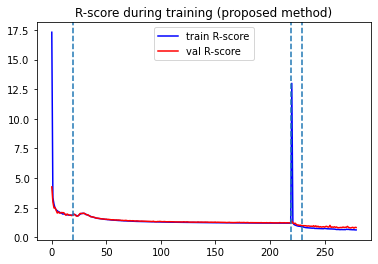

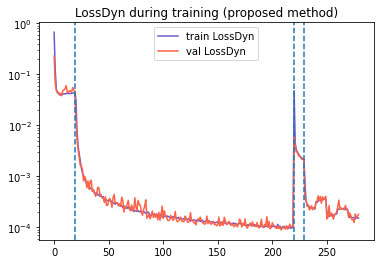

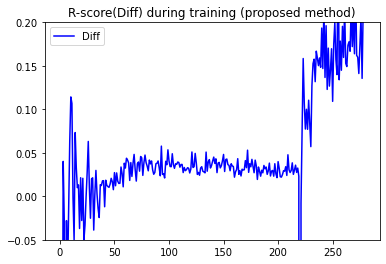

In [3]:
start = 0
end = val_loss_rec_new.shape[0]
plt.figure(1)
plt.title('R-score during training (proposed method)')
plt.plot(np.arange(start, end), train_loss_rec_new[start:end], 'b-')
plt.plot(np.arange(start, end), val_loss_rec_new[start:end], 'r-')
plt.axvline(x=19.5, linestyle='--')#, xmin=0.1, xmax=0.9)
plt.axvline(x=19.5+train_loss_new[1]["train_loss_rec"].shape[0], linestyle='--')
plt.axvline(x=29.5+train_loss_new[1]["train_loss_rec"].shape[0], linestyle='--')
plt.legend(["train R-score", "val R-score"])
# plt.ylim((0.5, 3.0))

plt.figure(2)
plt.title('LossDyn during training (proposed method)')
plt.plot(np.arange(start, end), train_loss_dyn_new[start:end], c='#6A5ACD', ls='-')
plt.plot(np.arange(start, end), val_loss_dyn_new[start:end], c='#FF6347', ls='-')
plt.legend(["train LossDyn", "val LossDyn"])
plt.axvline(x=19.5, linestyle='--')#, xmin=0.1, xmax=0.9)
plt.axvline(x=19.5+train_loss_new[1]["train_loss_rec"].shape[0], linestyle='--')
plt.axvline(x=29.5+train_loss_new[1]["train_loss_rec"].shape[0], linestyle='--')
plt.yscale('log')

plt.figure(9)
plt.title('R-score(Diff) during training (proposed method)')
plt.plot(np.arange(start, end), val_loss_rec_new[start:end] - train_loss_rec_new[start:end], 'b-')
plt.legend(["Diff"])
plt.ylim((-0.05, 0.2))

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_head  = Unet_models.L63_UnetConvRec_head().to(device)
model_dyn   = Unet_models.L63_UnetConvRec_dyn().to(device)
model_sup   = Unet_models.L63_UnetConvRec_sup().to(device)

model_head.load_state_dict(torch.load("ckpts/" + dir_name + "/finetune7_head_epoch10"))
model_dyn.load_state_dict(torch.load("ckpts/" + dir_name + "/finetune7_dyn_epoch10"))
model_sup.load_state_dict(torch.load("ckpts/" + dir_name + "/finetune7_sup_epoch10"))

model = Unet_models.L63_DARNN(model_head, model_dyn, model_sup, 3)

In [6]:
test_set_npz = np.load('L63_test_set/testset_1.npz')
x_test_obs = test_set_npz['x_test_obs']
x_test = test_set_npz['x_test']
mask_test = test_set_npz['mask_test']

meanTr = test_set_npz['mean']
stdTr = test_set_npz['std']

In [8]:
batchsize = 8

test_dataset_G = torch.utils.data.TensorDataset(torch.Tensor(x_test_obs),  torch.Tensor(x_test), torch.Tensor(mask_test)) 

dataloaders_G = {
    'test': torch.utils.data.DataLoader(test_dataset_G, batch_size=batchsize, shuffle=False, num_workers=4, pin_memory=True),
}

dataset_sizes_G = {'test': len(test_dataset_G)}

y_test  = np.zeros(x_test.shape)

since = time.time()

for phase in ['test']:
    model.eval()

    running_loss_rec    = 0.0
    running_loss_dyn    = 0.0
    running_loss_dyn_bg = 0.0
    running_loss_R      = 0.0
    running_loss_I      = 0.0
    num_loss            = 0
    
    idx = 0 # counter
    
    # Iterate over data.
    for inputs, targets, mask, in dataloaders_G[phase]:
        mask        = mask.to(device)
        targets     = targets.to(device)
        inputs      = inputs.to(device)

        with torch.set_grad_enabled(True): 
                        
#             outputs    = model_head(inputs[:,0:1,:] * mask[:,0:1,:])
#             outputs    = model_dyn(outputs)
#             outputs    = model_sup(outputs)
#             outputs    = model_dyn(outputs)
#             outputs    = model_sup(outputs)
#             outputs    = model_dyn(outputs)
#             outputs    = model_sup(outputs)
#             outputs    = model_dyn(outputs)
            
#             outputs    = model(inputs[:,0:1,:], mask[:,0:1,:])[-1]

            loss_rec   = torch.mean((outputs - targets)**2)
            loss_dyn_bg = utils.dynamic_loss(outputs, 1, meanTr, stdTr, 3)
            loss_dyn    = utils.dynamic_loss(outputs, 1, meanTr, stdTr, 1)

            loss_R     = torch.sum((outputs - targets)**2 * mask) / torch.sum(mask)
            loss_I     = torch.sum((outputs - targets)**2 * (1 - mask)) / torch.sum(1 - mask)
            
            y_test[idx:idx+inputs.size(0),:,:]  = outputs.cpu().detach().numpy()
            
            idx += inputs.size(0)

        running_loss_rec         += loss_rec.item()    * inputs.size(0) * stdTr**2
        running_loss_dyn         += loss_dyn.item()    * inputs.size(0) * stdTr**2
        running_loss_dyn_bg      += loss_dyn_bg.item() * inputs.size(0) * stdTr**2
        running_loss_R           += loss_R.item()      * inputs.size(0) * stdTr**2
        running_loss_I           += loss_I.item()      * inputs.size(0) * stdTr**2
        num_loss                 += inputs.size(0)

    epoch_loss_rec       = running_loss_rec    / num_loss
    epoch_loss_dyn       = running_loss_dyn    / num_loss
    epoch_loss_dyn_bg    = running_loss_dyn_bg / num_loss
    epoch_loss_R         = running_loss_R      / num_loss
    epoch_loss_I         = running_loss_I      / num_loss

    print('{} rec loss: {:.4e} dyn loss: {:.4e} dyn loss (bg): {:.4e} loss_R: {:.4e} loss_I: {:.4e}'.format(
        phase, epoch_loss_rec, epoch_loss_dyn, epoch_loss_dyn_bg, epoch_loss_R, epoch_loss_I))


time_elapsed = time.time() - since
print('Test complete in {:.0f}m {:.0f}s {:.0f}ms'.format(
    time_elapsed // 60, time_elapsed % 60, (time_elapsed * 1000) % 1000))

test rec loss: 7.5060e-01 dyn loss: 1.5216e-04 dyn loss (bg): 7.9662e-03 loss_R: 2.3755e-01 loss_I: 7.7013e-01
Test complete in 0m 6s 877ms


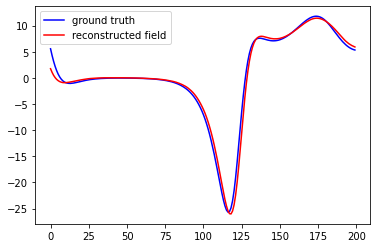

In [10]:
import matplotlib.pyplot as plt 
idx = 10
k   = 1
plt.plot(x_test[idx, k, :] * stdTr + meanTr,'b-')
plt.plot(y_test[idx, k, :] * stdTr + meanTr,'r-')
plt.legend(['ground truth', 'reconstructed field'])

1.3584170208105932


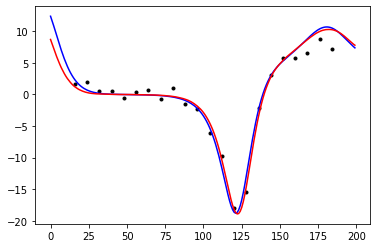

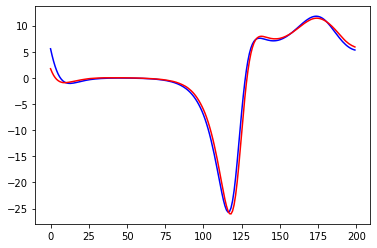

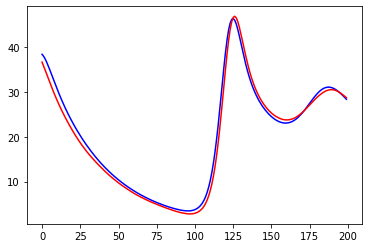

In [11]:
for jj in range(0,3):
    plt.figure(jj+1)
    if jj == 0:
        plt.plot(np.array(range(16, 192, 8)), x_test_obs[idx, jj, 16:192:8] * stdTr + meanTr, 'k.')
    plt.plot(x_test[idx, jj, :] * stdTr + meanTr,'b-')
    plt.plot(y_test[idx, jj, :] * stdTr + meanTr,'r-')
#     if jj == 0:
#         plt.legend(['obs', 'ground truth', 'UnetConvRec'])
#     else:
#         plt.legend(['ground truth', 'UnetConvRec'])
    
print(np.mean((x_test[idx, :, :]-y_test[idx, :, :])**2*stdTr**2))